In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
from sktime.datasets import load_japanese_vowels

In [50]:
X, y = load_japanese_vowels(return_X_y=True)

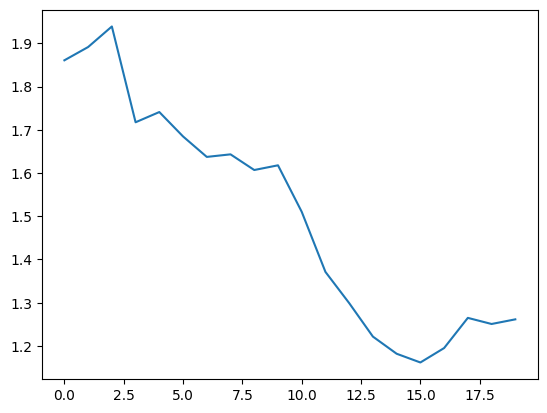

In [15]:
plt.plot(X["dim_0"][0])

In [90]:
# Fonctions utiles 
def normalize_series(series, column_mean):
    if series is not None:
        return series.to_numpy() - column_mean
    return series

def normalize(X) :
    means = X.map(lambda series: np.mean(series.to_numpy()) if series is not None else np.nan)

    # Calcul de la moyenne par colonne des moyennes
    column_means = means.mean()

    # Appliquer la normalisation à chaque cellule
    normalized_X = pd.DataFrame()
    for col_name in X.columns:
        normalized_X[col_name] = X[col_name].apply(normalize_series, args=(column_means[col_name],))

    # Afficher les premières lignes des DataFrame normalisés pour vérifier
    return normalized_X

def cov_matrix(df):

    cov_matrices = []
    for index, row in normalized_X.iterrows():
        row_data = np.stack(row.values)

        cov_matrix = np.cov(row_data, bias=True)  

        cov_matrices.append(cov_matrix)
    return cov_matrices

def CPCA(Sigma, p):
    mean_cov = np.zeros_like(Sigma[0])
    for cov in Sigma :
        mean_cov += cov
    mean_cov /= len(Sigma)
    u, _, _ = np.linalg.svd(mean_cov)
    # u = np.asarray(u)
    return u[:, :p]

In [143]:
# On fait comme dans l'article, pas au nombre d'itérations mais on regarde l'évolution et on arrête en dessous d'un certain seuil
def Mc2PCA(df, K, p, seuil, max_iter= 100):
    # Normalize the data
    df = normalize(df)
    # Compute the covariance matrices
    cov_matrices = cov_matrix(df)
    n = df.shape[0]
    L = n//K
    extras = n % K
    start = 0
    indices = np.arange(n)
    idx = []
    S = []
    for k in range(0,K):
        end = start + L + (1 if k < extras else 0)
        idx.append(indices[start : end])
        start = end
        selected_cov = [cov_matrices[i] for i in idx[k]]
        S.append(CPCA(selected_cov, p))
    
    E = [np.inf]
    for t in tqdm(range(1, max_iter + 1)):
        Error = np.zeros((n,K))
        new_idx = [[] for _ in range(K)] #index
        sst = []
        for k in range(K):
            sst.append(np.matmul(S[k], S[k].T))
            for i in range(n):
                Y = np.matmul(df.iloc[i],sst[k])
                Error[i,k]= np.linalg.norm(np.linalg.norm(df.iloc[i] - Y))
        I = np.argmin(Error, axis=1)
        v = np.min(Error, axis=1)
        E.append(np.sum(v))
        for i in range(n):
            new_idx[I[i]].append(i)
        if np.abs(E[t-1] - E[t]) < seuil:
            break
        for k in range(0,K):
            selected_cov = [cov_matrices[i] for i in new_idx[k]]
            S[k] = CPCA(selected_cov, p)
    return new_idx, E

In [144]:
K = 9
p = 3
seuil = 1e-7
new_idx, E = Mc2PCA(X, K, p, seuil, max_iter= 100)

100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


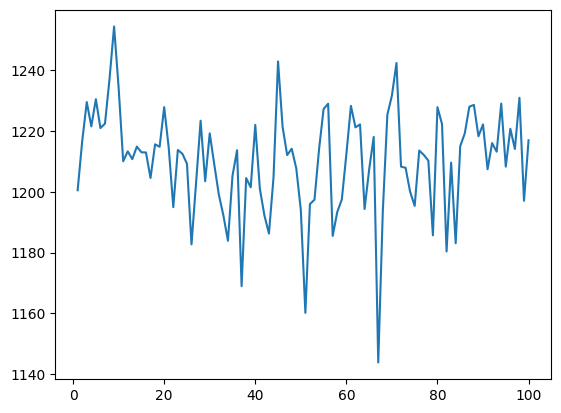

In [145]:
plt.plot(E)